In [1]:
from numpy.random import randint 
import numpy as np
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import csv

## Parameters

In [2]:
# parameters

modelPath = ""
modelName = "NNMedian.keras"

n_arrays = 2_000
array_length = 4
max_digit = 10
epochs = 150
batch_size = 32
neurons = 2
n_layers = 2
stop_perc = 5

In [3]:
# calculate number of permutation 
print("number of permutation: ", max_digit**array_length)
print("percentage of view:", (n_arrays * 0.5) * 100 / max_digit**array_length, "%")

number of permutation:  10000
percentage of view: 10.0 %


## Dataset

In [4]:
# generate input and output data
# give different max value 

input_arrays = []
label_arrays = []
for _ in range(n_arrays):
    temp_array = randint(0, randint(max_digit // 2, max_digit), array_length)
    temp_label = np.sort(temp_array)
    
    input_arrays.append(temp_array)
    label_arrays.append(temp_label)

In [5]:
print(len(input_arrays), len(label_arrays))
print(input_arrays[:3])
print(label_arrays[:3])

2000 2000
[array([1, 5, 4, 1]), array([7, 6, 7, 6]), array([7, 0, 2, 6])]
[array([1, 1, 4, 5]), array([6, 6, 7, 7]), array([0, 2, 6, 7])]


In [6]:
# normalize 

for i in range(len(input_arrays)):
    input_arrays[i] = input_arrays[i].astype("float32") / (max_digit - 1)
    label_arrays[i] = label_arrays[i].astype("float32") / (max_digit - 1)

In [7]:
# make np array 

input_arrays = np.array(input_arrays)
label_arrays = np.array(label_arrays)

In [8]:
print(input_arrays[:1])
print(label_arrays[:1])

[[0.11111111 0.5555556  0.44444445 0.11111111]]
[[0.11111111 0.11111111 0.44444445 0.5555556 ]]


In [9]:
# split data 

n_train = int(0.5 * n_arrays)
n_val = int(0.25 * n_arrays)
n_eval = n_arrays - n_train - n_val

data_test = input_arrays[:n_train]
data_validation = input_arrays[n_train:(n_train+n_val)]
data_evaluation = input_arrays[n_train + n_val:]

label_test = label_arrays[:n_train]
label_validation = label_arrays[n_train:(n_train+n_val)]
label_evaluation = label_arrays[n_train + n_val:]

In [10]:
print(data_test.shape, data_validation.shape, data_evaluation.shape)
print(label_test.shape, label_validation.shape, label_evaluation.shape)

(1000, 4) (500, 4) (500, 4)
(1000, 4) (500, 4) (500, 4)


## Model

In [11]:
inputs = keras.Input(shape=(array_length))
x = layers.Dense(neurons, activation="relu") (inputs)
x = layers.Dense(neurons, activation="relu") (x)
outputs = layers.Dense(array_length, activation="sigmoid") (x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 2)                 10        
                                                                 
 dense_1 (Dense)             (None, 2)                 6         
                                                                 
 dense_2 (Dense)             (None, 4)                 12        
                                                                 
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(
    optimizer="rmsprop", 
    loss="binary_crossentropy", 
    metrics=["mae"]
    )

In [13]:
callbacks = [ 
    keras.callbacks.ModelCheckpoint(
        filepath=modelPath + modelName, 
        monitor="val_mae", 
        save_best_only=True),
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=int(epochs/100*stop_perc))
    ]   

In [14]:
history = model.fit(
    data_test, 
    label_test, 
    epochs=epochs, 
    batch_size=batch_size,
    validation_data=(data_validation, label_validation),
    callbacks=callbacks
    )

Epoch 1/150
32/32 [==============================] - 2s 17ms/step - loss: 0.6867 - mae: 0.2400 - val_loss: 0.6816 - val_mae: 0.2365
Epoch 2/150
32/32 [==============================] - 0s 4ms/step - loss: 0.6788 - mae: 0.2330 - val_loss: 0.6738 - val_mae: 0.2293
Epoch 3/150
32/32 [==============================] - 0s 4ms/step - loss: 0.6715 - mae: 0.2266 - val_loss: 0.6665 - val_mae: 0.2224
Epoch 4/150
32/32 [==============================] - 0s 4ms/step - loss: 0.6645 - mae: 0.2205 - val_loss: 0.6595 - val_mae: 0.2161
Epoch 5/150
32/32 [==============================] - 0s 4ms/step - loss: 0.6579 - mae: 0.2148 - val_loss: 0.6525 - val_mae: 0.2101
Epoch 6/150
32/32 [==============================] - 0s 4ms/step - loss: 0.6514 - mae: 0.2093 - val_loss: 0.6458 - val_mae: 0.2045
Epoch 7/150
32/32 [==============================] - 0s 6ms/step - loss: 0.6453 - mae: 0.2044 - val_loss: 0.6397 - val_mae: 0.1998
Epoch 8/150
32/32 [==============================] - 0s 7ms/step - loss: 0.6396 - 

## Performance

In [15]:
mae = history.history["mae"]
val_mae = history.history["val_mae"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
x_epochs = range(1, len(val_mae) + 1)

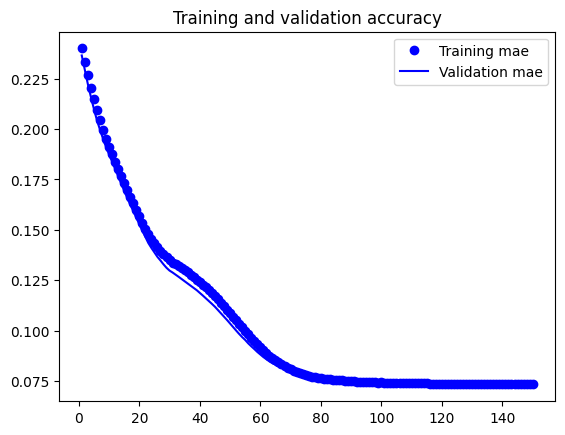

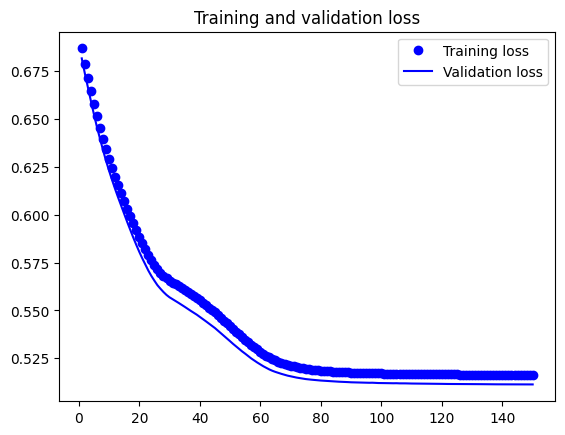

In [16]:
plt.plot(x_epochs, mae, "bo", label="Training mae")
plt.plot(x_epochs, val_mae, "b", label="Validation mae")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(x_epochs, loss, "bo", label="Training loss")
plt.plot(x_epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [17]:
model_best = keras.models.load_model(modelPath + modelName)

eval_loss, eval_mae = model_best.evaluate(data_evaluation, label_evaluation)
eval_mae_perc = eval_mae * (max_digit - 1)

print(f"Evaluation accuracy: {eval_mae:.3f}")
print(f"Evaluation mae denormalized: {eval_mae_perc:.2f}")

16/16 [==============================] - 0s 1ms/step - loss: 0.5183 - mae: 0.0736
Evaluation accuracy: 0.074
Evaluation mae denormalized: 0.66


In [18]:
def denormalize(x):
    x = x * (max_digit - 1)
    return x

def rounding(x):
    x = round(x, 0)
    return x

predictions = model_best.predict(data_evaluation)
targets = label_evaluation

16/16 [==============================] - 0s 1ms/step


In [19]:
# denormalize and round 

predictions_denorm = []
targets_denorm = []
for i in range(len(predictions)):
    temp_pred_denorm_array = []
    temp_targ_denorm_array = []
    for ii in range(array_length):
        temp_pred_denorm_array.append(rounding(denormalize(float(predictions[i][ii]))))
        temp_targ_denorm_array.append(rounding(denormalize(targets[i][ii])))
    predictions_denorm.append(temp_pred_denorm_array)
    targets_denorm.append(temp_targ_denorm_array)

print(len(predictions_denorm), len(targets_denorm))
print(predictions_denorm[:3])
print(targets_denorm[:3])

500 500
[[3.0, 5.0, 6.0, 7.0], [0.0, 1.0, 2.0, 4.0], [0.0, 1.0, 2.0, 4.0]]
[[3.0, 4.0, 7.0, 8.0], [0.0, 2.0, 2.0, 3.0], [0.0, 1.0, 1.0, 4.0]]


In [20]:
# plot the prediction and target by merging all the arrays 

index_x = 0
x_merged = []
pred_merged = []
targ_merged = []
for i in range(len(predictions_denorm)):
    for ii in range(array_length):
        index_x += 1
        x_merged.append(index_x)
        pred_merged.append(predictions_denorm[i][ii])
        targ_merged.append(targets_denorm[i][ii])

In [21]:
# calculate error that are elements out of place 

miss = 0
hit = 0
tot = len(pred_merged)
for i in range(len(pred_merged)):
    if (pred_merged[i] == targ_merged[i]):
        hit += 1
    else:
        miss += 1
perc = round(hit * 100 / tot, 1)

print(f"tot: {tot}, hit: {hit}, miss: {miss}, perc hit: {perc}%")

tot: 2000, hit: 951, miss: 1049, perc hit: 47.5%


In [22]:
# calculate mean absolute error 
# need to calculate the maximum for every array as they are different 

def mean_absolute_error_array(pre_denorm, tar_denorm):
    N = len(pre_denorm)
    errors_array = []
    for i in range(N):
        temp_error = 0
        temp_sum = 0
        n = array_length
        for ii in range(n):
            temp_sum += abs(pre_denorm[i][ii] - tar_denorm[i][ii])
        temp_error = temp_sum / n
        errors_array.append(temp_error)
    return errors_array

def mean_absolute_error(mae_array):
    return np.mean(mae_array)

def mean_absolute_error_perc(mae_array, tar_denorm):
    # calcualte the max value 
    # take the target for the maximum 
    max_val_array = []
    for i in range(len(tar_denorm)):
        max_val_array.append(np.max(tar_denorm[i]))
    
    mae_perc_array = []
    for i in range(len(tar_denorm)):
        if max_val_array[i] != 0:
            mae_perc_array.append(mae_array[i] * 100 / max_val_array[i])
        else:
            mae_perc_array.append(mae_array[i] * 100)
    
    mae_perc = np.mean(mae_perc_array)
    
    return max_val_array, mae_perc_array, mae_perc

mae_array = mean_absolute_error_array(predictions_denorm, targets_denorm)
mae = mean_absolute_error(mae_array)
max_val_array, mae_perc_array, mae_perc = mean_absolute_error_perc(mae_array, targets_denorm)
mae_perc = round(mae_perc, 1)

# print(predictions_denorm[:3])
# print(targets_denorm[:3])
print(f"mean absolute error of every array: {mae_array[:3]}")
print(f"max value of every array: {max_val_array[:3]}")
print(f"mae perc of every array: {mae_perc_array[:3]}")
print()
print(f"mean absolute error: {mae}")
print(f"mean absolute error perc: {mae_perc}%")

mean absolute error of every array: [0.75, 0.5, 0.25]
max value of every array: [8.0, 3.0, 4.0]
mae perc of every array: [9.375, 16.666666666666668, 6.25]

mean absolute error: 0.606
mean absolute error perc: 12.9%


In [23]:
print("array_length: ", array_length)
print(len(pred_merged), len(targ_merged))
print(pred_merged[:(2*array_length)])
print(targ_merged[:(2*array_length)])

array_length:  4
2000 2000
[3.0, 5.0, 6.0, 7.0, 0.0, 1.0, 2.0, 4.0]
[3.0, 4.0, 7.0, 8.0, 0.0, 2.0, 2.0, 3.0]


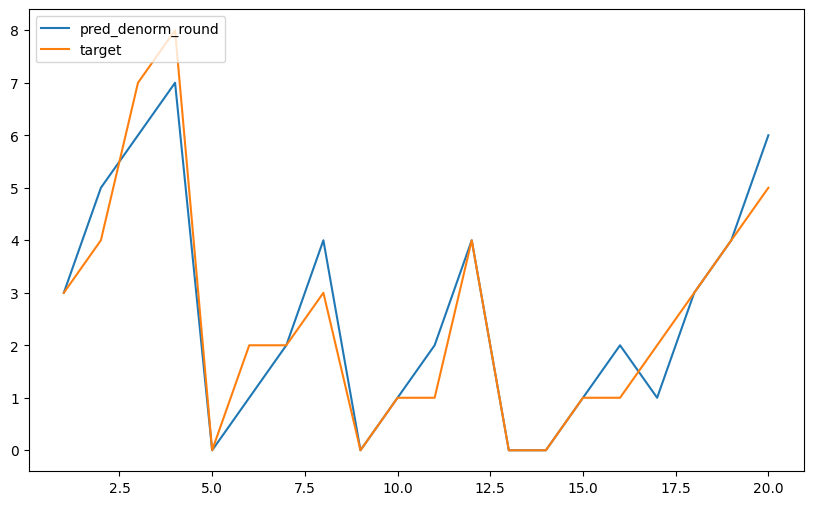

In [24]:
plot_length = array_length * 5

plt.figure(figsize=(10, 6))
plt.plot(x_merged[:plot_length], pred_merged[:plot_length], label="pred_denorm_round")
plt.plot(x_merged[:plot_length], targ_merged[:plot_length], label="target")
plt.legend(loc="upper left")
plt.show()

## Custom Prediction

In [25]:
def pred_norm(xs):
    xs = xs.astype("float32") / (max_digit - 1)
    return xs

def pred_denorm(xs):
    xs = xs * (max_digit - 1)
    return xs

def pred_round(xs):
    for i in range(len(xs)):
        xs[i] = round(xs[i], 0)
    return xs

In [26]:
xs = [4, 2, 6, 9]
# xs = randint(0, randint(max_digit // 2, max_digit), array_length)

p_array = np.array([np.array(xs)])
p_array_sorted = np.sort(p_array)

# normalize before input 
predictions = model_best.predict(pred_norm(p_array))

opt_predictions = pred_round(pred_denorm(predictions[0]))

print(f"input: {p_array}")
print(f"target sorted: {p_array_sorted}")
print(f"prediction raw: {predictions}")
print(f"prediction opt: {opt_predictions}")

1/1 [==============================] - 0s 27ms/step
input: [[4 2 6 9]]
target sorted: [[2 4 6 9]]
prediction raw: [[0.40651318 0.5958576  0.73079723 0.7984272 ]]
prediction opt: [4. 5. 7. 7.]


## Net Weights Biases

In [27]:
w1 = model_best.layers[1].get_weights()[0].tolist()
b1  = model_best.layers[1].get_weights()[1].tolist()
w2 = model_best.layers[2].get_weights()[0].tolist()
b2  = model_best.layers[2].get_weights()[1].tolist()
w3 = model_best.layers[3].get_weights()[0].tolist()
b3 = model_best.layers[3].get_weights()[1].tolist()

print(w1)
print(b1)
print()
print(w2)
print(b2)
print()
print(w3)
print(b3)

[[-0.21394069492816925, -1.6555784940719604], [-0.7052624821662903, -0.16084568202495575], [-0.6815492510795593, -0.20693667232990265], [-0.6777378916740417, -0.3010774552822113]]
[1.3768173456192017, 0.9910971522331238]

[[-0.17687058448791504, 2.528022289276123], [-0.4891108274459839, 1.171981930732727]]
[0.0, 1.5325495041906834e-05]

[[-0.4009826183319092, 0.6186366081237793, 0.7200775146484375, -0.5683023929595947], [-1.1328788995742798, -0.8289250135421753, -0.7386038899421692, -0.5874789953231812]]
[-0.3783811330795288, 0.38824722170829773, 0.99868243932724, 1.3765027523040771]


In [28]:
# build header

def build_header_element(L_n, n_neurons):
    weight = "w" + str(L_n) + "_" + str(n_neurons)
    bias = "b" + str(L_n) + "_" + str(n_neurons)
    return weight, bias

def add_to_header(net, L_n, n_neurons):
    weight, bias = build_header_element(L_n, n_neurons)
    net.append(weight)
    net.append(bias)

# write data 
def add_data(header, max_column, *parameters):

    net_list = []

    for i in range(len(parameters)):
        temp_list = []
        for ii in range(len(parameters[i])):
            if type(parameters[i][ii]) is list:
                for iii in range(len(parameters[i][ii])): 
                    temp_list.append(parameters[i][ii][iii])
            else:
                temp_list.append(parameters[i][ii])
        net_list.append(temp_list)
    
    # print(header)
    # print(net_list)
    
    with open("net_weight_bias.csv", 'w') as f:
        writer = csv.writer(f)
        # header 
        writer.writerow(header)
        # parameters
        for i in range(max_column):
            row = []
            for ii in range(len(header)):
                try:
                    row.append(net_list[ii][i])
                except:
                    row.append("")
            writer.writerow(row)

In [29]:
# add to csv

net_header = []
neurons = [2, 2, 4]
max_column = 2 * 4

add_to_header(net_header, 1, neurons[0])
add_to_header(net_header, 2, neurons[1])
add_to_header(net_header, 3, neurons[2])

add_data(
    net_header,
    max_column,
    w1, b1,
    w2, b2,
    w3, b3,
)